In [6]:
from benchmark_demo.Benchmark import Benchmark
from benchmark_demo.ResultsInterpreter import ResultsInterpreter
import pickle
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as spst
import matplotlib.colors as mcolors

In [7]:
def clopper_pearson(k, n, alpha):
    """
    Clopper-Pearson confidence interval for Bernoulli parameter
    alpha: confidence level
    k: number of successes
    n: number of observations
    """
    lb = spst.beta.ppf(alpha/2, k, n-k+1)
    ub = spst.beta.ppf(1 - alpha/2, k+1, n-k)
    return lb, ub

def plot_power_plots(data, radius, alpha = 0.05, ax = None , cfact = 1):
    dset_aux = list(data.items())[0][1]
    repetitions = dset_aux.shape[0]
    bonf_correction = len(radius)*len(data)*cfact

    c = [i for k,i in enumerate(mcolors.TABLEAU_COLORS) if k<len(data)]
    c = ['tab:blue', 'tab:green']

    for i, label in enumerate(data):
        dset = data[label]
        beta = np.mean(dset, axis=0)
        k1 = (beta*repetitions).astype(int)

        ax.plot(radius, beta, '--o', color = c[i], markersize=3, linewidth=2.25) #
        ax.annotate(''.join(('$',label[0],'$')), (0.3, beta[0]-0.1), color = c[i], fontsize = 14) 

        error_beta = np.array(clopper_pearson(k1, repetitions, alpha/bonf_correction)) # Bonferroni correction here!
        yerr1 = np.abs(error_beta - beta)
        yerr1[np.isnan(yerr1)] = 0
        (_, caps, _) = ax.errorbar(radius, beta, yerr=yerr1, color = c[i], fmt='.', markersize=6, elinewidth=1, capsize=3) # color = c[0],
        for cap in caps:
            cap.set_markeredgewidth(1)

        ax.set_ylim((-0.1,1.1))
        ax.set_xlim((0, 2.5))
        ax.set_ylabel('Test Power', fontsize = 14)
        ax.set_xlabel('$r_{max}$', fontsize = 14)
        ax.set_yticks((0.0, 0.25, 0.5, 0.75, 1.0))
        ax.set_yticklabels(('0.0',None,'0.5',None,'1.0'))


In [8]:
filename = None
if filename is None:
    filename = '../results/last_benchmark_detection'

with open(filename + '.pkl', 'rb') as f:
    benchmark = pickle.load(f)  

print(isinstance(benchmark,Benchmark))
# print(benchmark.methods_ids)
# df = benchmark.get_results_as_df()
# print(df)

results_interpreter = ResultsInterpreter(benchmark)
df = results_interpreter.rearrange_data_frame()
radius = [0.5, 1.0, 2.0]
SNRin = [10, 20]

# Parameters used in the simulation.
parameters = [  {'statistic':'L',   'pnorm': 2,         'rmax': 0.5},
                {'statistic':'L',   'pnorm': 2,         'rmax': 1.0},
                {'statistic':'L',   'pnorm': 2,         'rmax': 2.0},
                {'statistic':'Frs', 'pnorm': 2,         'rmax': 0.5},
                {'statistic':'Frs', 'pnorm': 2,         'rmax': 1.0},
                {'statistic':'Frs', 'pnorm': 2,         'rmax': 2.0},
                {'statistic':'L',   'pnorm': np.inf,    'rmax': 0.5},
                {'statistic':'L',   'pnorm': np.inf,    'rmax': 1.0},
                {'statistic':'L',   'pnorm': np.inf,    'rmax': 2.0},
                {'statistic':'Frs', 'pnorm': np.inf,    'rmax': 0.5},
                {'statistic':'Frs', 'pnorm': np.inf,    'rmax': 1.0},
                {'statistic':'Frs', 'pnorm': np.inf,    'rmax': 2.0},]

True


C:\Users\juan_\Nextcloud\Miramont_Juan\python_code\gretsi_2022_benchmark\src\benchmark_demo\ResultsInterpreter.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df3 = df3.drop('level_1', 1)


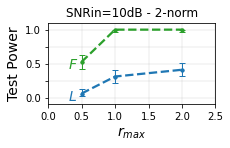

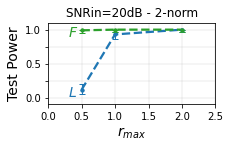

In [10]:
data = dict()
norm = 2 # np.inf

for snr in SNRin:
    for stat in ('L','Frs'):
        dset = list()
        params = [i for i in parameters if (i['statistic']==stat and i['pnorm']==norm)]
        for i in params:
            df_aux = df[(df['Parameter']==str(i)) & (df['SNRin']==snr)]
            aux = df_aux.iloc[:,-1].to_numpy()
            # print(aux.shape)
            dset.append(df_aux.iloc[:,-1].to_list())
            
        dset = np.array(dset).T
        data[stat] = dset

    # print(data)

    fig, ax = plt.subplots(1,1)
    plot_power_plots(data, radius, alpha = 0.05, ax = ax, cfact = 2)
    if norm == 2:
        ax.set_title('SNRin={}dB - 2-norm'.format(snr))
    if norm == np.inf:
        ax.set_title('SNRin={}dB - $\infty$-norm'.format(snr))
    plt.grid(True, linewidth = 0.25)
    fig.set_size_inches((3,1.5))
    plt.show()
    # fig.savefig('results/figures/plot_power_'+ str(snr) +'_'+ str(norm) +'.pdf', bbox_inches='tight')# , format='svg')